In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class MMSERDataset(Dataset):
    """multi model ser dataset."""
    
    def __load_audio__(self, spec_path, max_len):
        # load all spectrogram
        self.spec_fn_list = os.listdir(spec_path)
        self.spec_dict = {}
        for fn in self.spec_fn_list:
            self.spec_dict[fn] = np.load(os.path.join(spec_path, fn))
        # pad
        spec_list = list(self.spec_dict.values())
        spec_max_len = max([spec.shape[1] for spec in spec_list])
        padded_spec_list = [np.pad(x, ((0, 0), (0, spec_max_len - x.shape[1])), 'constant', constant_values=0)
                           for x in spec_list]
        # trunc
        padded_spec_array = np.array(padded_spec_list)
        padded_spec_array.shape
        self.spec_array = padded_spec_array[:, :, :max_len]
            
    def __load_label__(self, cutmap_path):
        pass
    
    def __load_text__(self, text_path):
        pass
    
    def __init__(self, spec_path, max_len=1024):
        self.__load_audio__(spec_path, max_len)
        
    def __len__(self):
        return self.spec_array.shape[0]
    
    def __getitem__(self, idx):
        return {
            "spec": self.spec_array[idx]
        }

In [3]:
mmser_ds = MMSERDataset("E:/datasets/preprocessed/spectrogram/librosa")

(128, 1024)

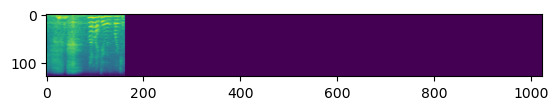

In [7]:
plt.imshow(mmser_ds[-10]["spec"])
mmser_ds[-10]["spec"].shape